<a href="https://colab.research.google.com/github/carloslara99/Xray-Penumonia/blob/master/Xray_Pneumonia_Classification_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Xray Pneumonia Classification_Wk 04_Siraj_ML

### Retrain the 'inception v3' image classifier on the pneumonia dataset using Tensorflow+Keras

In [0]:
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import Xception, preprocess_input
from keras.models import load_model
import keras.callbacks as kcall
import numpy as np
import matplotlib.pyplot as plt
import os, math, json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from glob import glob 
import seaborn as sns
from random import shuffle
import random
from tqdm import tqdm  
import cv2 
import skimage
from skimage.transform import resize

## Import Data

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle!mkdir -p ~/.kaggle

     |████████████████████████████████| 61kB 2.4MB/s 


In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"carloslara99","key":"b13a73d56cdb5004e54693fc0864dc8b"}'}

In [0]:
!cp kaggle.json ~/.kaggle/

In [0]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 1.15G/1.15G [00:07<00:00, 172MB/s]
100% 1.15G/1.15G [00:07<00:00, 156MB/s]


In [0]:
# Change the permission
!chmod 600 ~/.kaggle/kaggle.json


In [0]:
!unzip \chest-xray-pneumonia.zip

Archive:  chest-xray-pneumonia.zip
  inflating: chest_xray.zip          


In [0]:
ls

chest-xray-pneumonia.zip  chest_xray.zip  kaggle.json  sample_data/


In [0]:
!unzip \chest_xray.zip ;

Archive:  chest_xray.zip
   creating: chest_xray/
  inflating: chest_xray/.DS_Store    
   creating: __MACOSX/
   creating: __MACOSX/chest_xray/
  inflating: __MACOSX/chest_xray/._.DS_Store  
   creating: chest_xray/test/
  inflating: chest_xray/test/.DS_Store  
   creating: __MACOSX/chest_xray/test/
  inflating: __MACOSX/chest_xray/test/._.DS_Store  
   creating: chest_xray/test/PNEUMONIA/
  inflating: chest_xray/test/PNEUMONIA/person147_bacteria_706.jpeg  
   creating: __MACOSX/chest_xray/test/PNEUMONIA/
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person147_bacteria_706.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person100_bacteria_482.jpeg  
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person100_bacteria_482.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person78_bacteria_382.jpeg  
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person78_bacteria_382.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person124_bacteria_589.jpeg  
  inflating: __MACOSX/chest_xray/test/PNEUM

## Exploratory Data Analysis

In [0]:
from pathlib import Path

train_data = "./chest_xray/train/"
test_data = "./chest_xray/test/"
val_data = "./chest_xray/val/"

positive_class_folder_name = "PNEUMONIA"
negative_class_folder_name = "NORMAL"

P = Path(train_data + positive_class_folder_name + "/")
temp = list(P.glob("*.jpeg"))
print("Training-Pneumonia - %i " % len(temp))

P = P = Path(train_data + negative_class_folder_name + "/")
temp = list(P.glob("*.jpeg"))
print("Training-Normal - %i " % len(temp))

Training-Pneumonia - 3875 
Training-Normal - 1341 


In [0]:
from keras.preprocessing.image import ImageDataGenerator, load_img

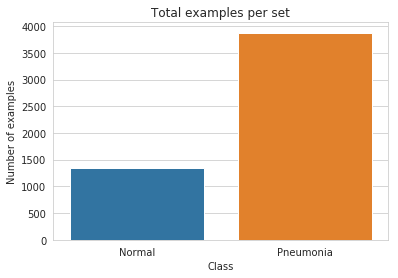

In [0]:
images_train_pneumonia = os.listdir(train_data+'PNEUMONIA/')
images_train_normal = os.listdir(train_data+'NORMAL/')
train_images = images_train_pneumonia + images_train_normal
sns.set_style('whitegrid')
sns.barplot(x=['Normal','Pneumonia'],y=[len(images_train_normal),len(images_train_pneumonia)])

plt.xlabel('Class')
plt.ylabel('Number of examples')
plt.title('Total examples per set')

plt.show()

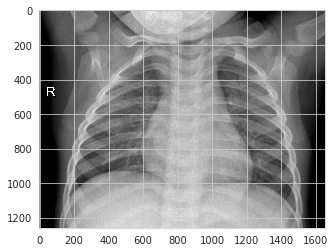

NORMAL


In [0]:
img_normal = load_img('chest_xray/train/NORMAL/IM-0460-0001.jpeg')
plt.imshow(img_normal)
plt.show()
print ('NORMAL')

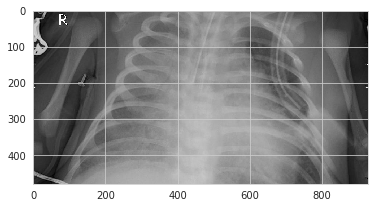

PENUMONIA


In [0]:
img_pneumonia = load_img('chest_xray/train/PNEUMONIA/person1265_bacteria_3223.jpeg')
plt.imshow(img_pneumonia)
plt.show()
print('PENUMONIA')

## Intilizing variables

In [0]:
classes = 2
learning_rate = 0.0001
image_height = 150
image_width = 150
image_size = [image_height, image_width]
channel = 3
total_train_images = 5216 
batch_size = 30 
batch_size_training_generator = 16
batch_size_test_generator = 16
batch_size_validation_generator = 16
EPOCHS = 10
resume_model = False

images_test_pneumonia = os.listdir(test_data + 'PNEUMONIA')
images_test_normal = os.listdir(test_data + 'NORMAL')

images_val_pneumonia = os.listdir(val_data + 'PNEUMONIA')
images_val_normal = os.listdir(val_data + 'NORMAL')

validation_steps = (len(images_test_normal)+len(images_test_pneumonia)) // batch_size
steps_per_epoch = (len(images_train_normal)+len(images_train_pneumonia))//batch_size


## Model Definition

In [0]:
#pretrained_model = tf.keras.applications.InceptionV3(input_shape=train_batches.image_shape, include_top=False)

pretrained_model = tf.keras.applications.InceptionV3(input_shape=[*image_size, 3], include_top=False)

model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='softmax')])

model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_3 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 36866     
Total params: 21,839,650
Trainable params: 36,866
Non-trainable params: 21,802,784
_________________________________________________________________


In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

val_datagen = ImageDataGenerator(rescale = 1./255) 

test_datagen = ImageDataGenerator(rescale = 1./255) 

In [0]:
  img_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

  train_img_generator = train_datagen.flow_from_directory(
        train_data,
        target_size = (image_width,image_height),
        batch_size = batch_size,
        class_mode = 'categorical')

  val_img_generator = img_generator.flow_from_directory(
                          val_data,
                          target_size = (image_width,image_height),
                          class_mode = 'categorical')
  test_img_generator = test_datagen.flow_from_directory(
                          test_data,
                          target_size = (image_width,image_height),
                          class_mode = 'categorical')
  
  for i, layer in enumerate(model.layers):
     print('Layer: ',i+1,' Name: ', layer.name)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Layer:  1  Name:  inception_v3
Layer:  2  Name:  flatten_3
Layer:  3  Name:  dense_3


## Model Training

In [0]:
history = model.fit_generator(train_img_generator,
                         steps_per_epoch = steps_per_epoch,
                         epochs = EPOCHS,
                         validation_data = test_img_generator,
                         validation_steps = validation_steps)

Epoch 1/10
173/173 [==============================] - 371s 2s/step - loss: 0.4237 - acc: 0.8760 - val_loss: 10.5587 - val_acc: 0.6282
Epoch 2/10
173/173 [==============================] - 365s 2s/step - loss: 0.3439 - acc: 0.9022 - val_loss: 7.7005 - val_acc: 0.6410
Epoch 3/10
173/173 [==============================] - 367s 2s/step - loss: 0.3580 - acc: 0.9076 - val_loss: 11.0827 - val_acc: 0.6282
Epoch 4/10
173/173 [==============================] - 369s 2s/step - loss: 0.3360 - acc: 0.9138 - val_loss: 3.5270 - val_acc: 0.6907
Epoch 5/10
173/173 [==============================] - 372s 2s/step - loss: 0.3253 - acc: 0.9184 - val_loss: 2.7067 - val_acc: 0.7131
Epoch 6/10
173/173 [==============================] - 364s 2s/step - loss: 0.3593 - acc: 0.9144 - val_loss: 5.7762 - val_acc: 0.6747
Epoch 7/10
173/173 [==============================] - 369s 2s/step - loss: 0.3270 - acc: 0.9196 - val_loss: 3.6880 - val_acc: 0.7324
Epoch 8/10
173/173 [==============================] - 374s 2s/step 

In [0]:
history_model = history

Results

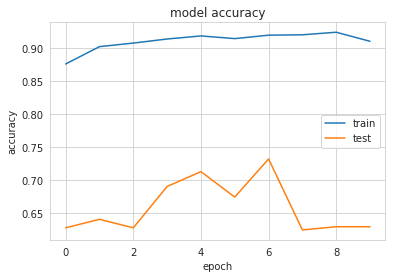

In [0]:
plt.plot(history_model.history['acc'])
plt.plot(history_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

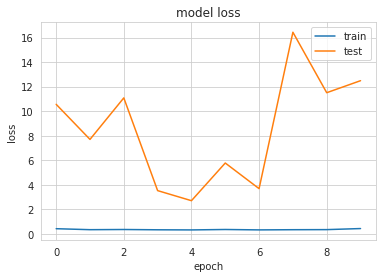

In [0]:
# summarize history for loss
plt.plot(history_model.history['loss'])
plt.plot(history_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
import imgaug.augmenters as iaa

Y_pred_train = model.predict_generator(train_img_generator)
y_pred_train = np.argmax(Y_pred_train, axis=1)
print('Confusion Matrix')
print(confusion_matrix(train_img_generator.classes, y_pred_train))
print('Classification Report')
target_names = ['Pneumonia', 'Normal']
print(classification_report(train_img_generator.classes, y_pred_train, target_names=target_names))

Confusion Matrix
[[   8 1333]
 [  21 3854]]
Classification Report
              precision    recall  f1-score   support

   Pneumonia       0.28      0.01      0.01      1341
      Normal       0.74      0.99      0.85      3875

    accuracy                           0.74      5216
   macro avg       0.51      0.50      0.43      5216
weighted avg       0.62      0.74      0.63      5216



In [0]:
Y_pred_test = model.predict_generator(test_img_generator)
y_pred_test = np.argmax(Y_pred_test, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_img_generator.classes, y_pred_test))
print('Classification Report')
target_names = ['Pneumonia', 'Normal']
print(classification_report(test_img_generator.classes, y_pred_test, target_names=target_names))

Confusion Matrix
[[  3 231]
 [  0 390]]
Classification Report
              precision    recall  f1-score   support

   Pneumonia       1.00      0.01      0.03       234
      Normal       0.63      1.00      0.77       390

    accuracy                           0.63       624
   macro avg       0.81      0.51      0.40       624
weighted avg       0.77      0.63      0.49       624



In [0]:
Y_pred_val = model.predict_generator(val_img_generator)
y_pred_val = np.argmax(Y_pred_val, axis=1)
print('Confusion Matrix')
print(confusion_matrix(val_img_generator.classes, y_pred_val))
print('Classification Report')
target_names = ['Pneumonia', 'Normal']
print(classification_report(val_img_generator.classes, y_pred_val, target_names=target_names))

Confusion Matrix
[[0 8]
 [0 8]]
Classification Report
              precision    recall  f1-score   support

   Pneumonia       0.00      0.00      0.00         8
      Normal       0.50      1.00      0.67         8

    accuracy                           0.50        16
   macro avg       0.25      0.50      0.33        16
weighted avg       0.25      0.50      0.33        16



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
y_values_predicted = y_pred_test
y_values_actual = test_img_generator.classes
filenames = test_img_generator.filenames

In [0]:
predictions = y_values_predicted
len(predictions)
len(y_values_actual)

624

In [0]:
actual_label = []

for i in range(len(y_values_actual )):
  if y_values_actual [i] == 0:
    actual_label.append('NORMAL')
  else:
      actual_label.append('PNEUMONIA') 

In [0]:
predicted_label = []

for i in range(len(y_values_predicted)):
  if y_values_predicted[i] == 0:
    predicted_label.append('NORMAL')
  else:
      predicted_label.append('PNEUMONIA') 

In [0]:
results=pd.DataFrame({'Filename':filenames,
                      'Predictions':predicted_label,
                      'Actual':actual_label})

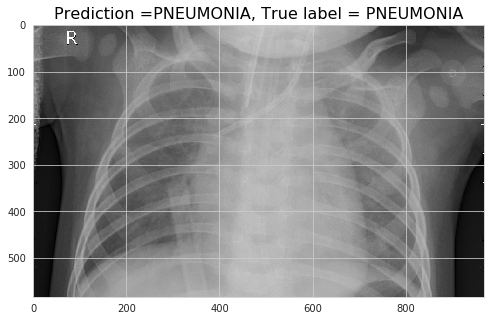

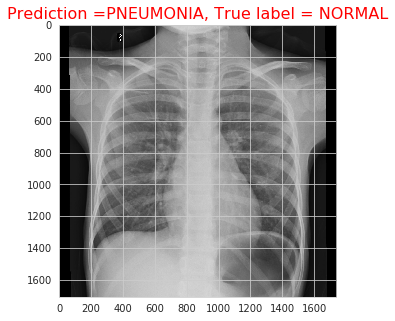

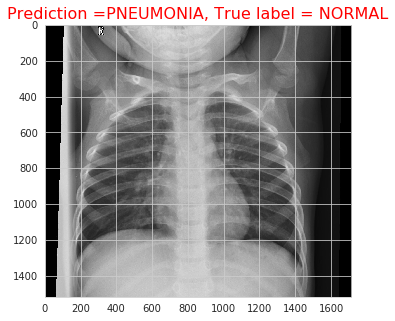

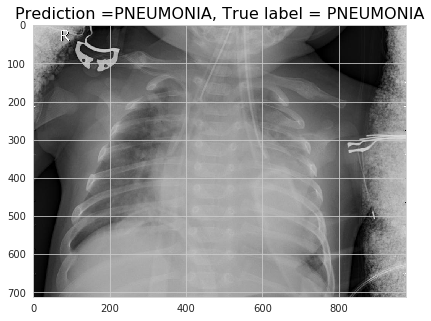

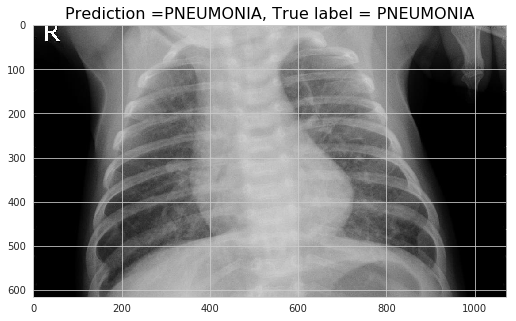

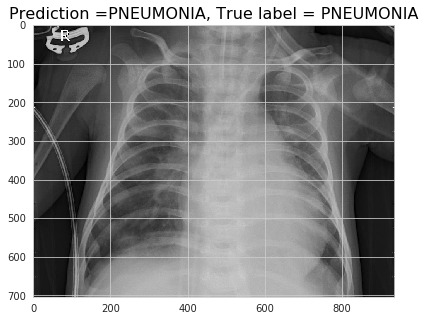

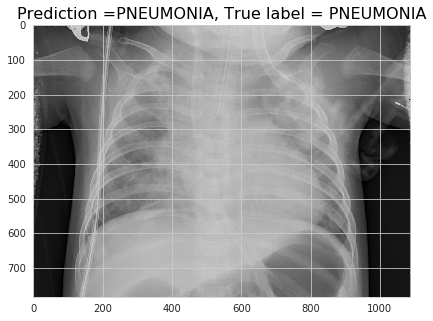

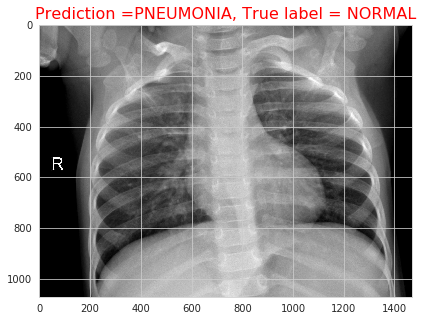

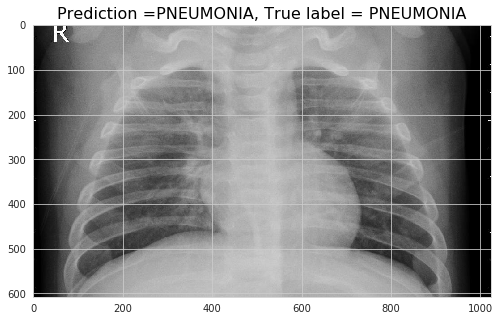

In [0]:
predictions = results['Predictions']
labels = results['Actual']

pictures = random.sample(range(0, len(predictions)), 9)

for i in pictures:
    true = predictions[i] == labels[i]
    imagepn = cv2.imread(test_data+filenames[i])
    plt.figure(figsize=(10,5))
    plt.title('Prediction ={}, True label = {}'.format(predictions[i],labels[i]), fontsize=16, color='red' if not true else 'black')
    plt.imshow(imagepn)

# End!